# Лабораторная работа 10

## Практика TensorFlow 2.x

Выполнил: 6231, Чаплыгин Алексей

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST.</br>
Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов.</br>
Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API.</br>
</br>
Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [1]:
# INIT
import tensorflow as tf
#import tensorflow_transform as tft

import numpy as np
import matplotlib.pyplot as plt
import keras

from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [2]:
!pip install --upgrade pip

In [3]:
tf.__version__

'2.10.0'

In [4]:
# Отображаем список физических устройств, видимых для среды выполнения хоста.
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя tf.random. Визуализируйте их разными цветами, используя matplotlib.

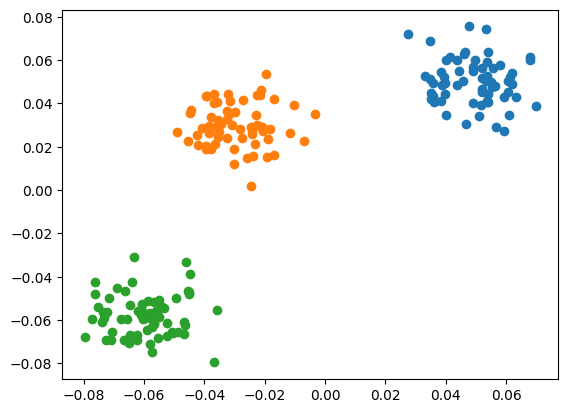

In [5]:
# Для смещения облаков
q = 0.05
a = 0.03
z = 0.06

# Формируем облака 
noise1 = tf.random.normal((64, 2), stddev=0.01) 
noise2 = tf.random.normal((64, 2), stddev=0.01) 
noise3 = tf.random.normal((64, 2), stddev=0.01) 

noise1 = noise1 + np.array([q, q])
noise2 = noise2 + np.array([-a, a])
noise3 = noise3 + np.array([-z, -z])

plt.scatter(noise1[:, 0], noise1[:, 1])
plt.scatter(noise2[:, 0], noise2[:, 1])
plt.scatter(noise3[:, 0], noise3[:, 1])

In [6]:
#print(noise1)

### 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [7]:
matrix = np.random.normal(size = (2,2))

matrix

array([[ 0.04757783,  0.76661682],
       [ 0.56729009, -0.00365636]])

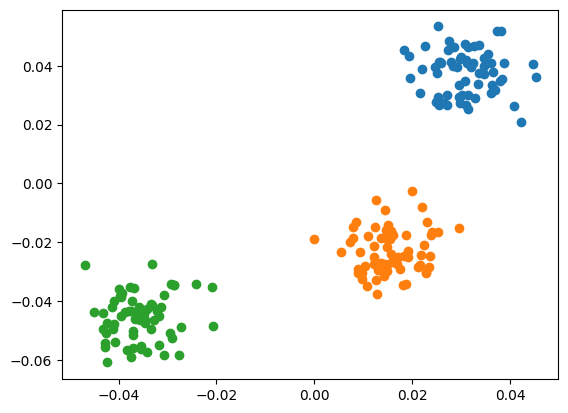

In [8]:
n1_new, n2_new, n3_new = [],[],[]

m_noise1 = tf.matmul(noise1, matrix)
m_noise2 = tf.matmul(noise2, matrix)
m_noise3 = tf.matmul(noise3, matrix)

plt.scatter(m_noise1[:, 0], m_noise1[:, 1])
plt.scatter(m_noise2[:, 0], m_noise2[:, 1])
plt.scatter(m_noise3[:, 0], m_noise3[:, 1])

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

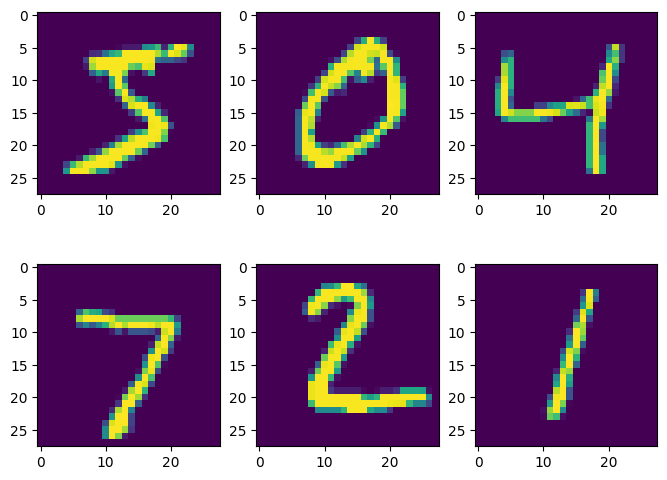

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

fig, ax = plt.subplots(2, 3, figsize=(8,6))

pcm = ax[0][0].imshow(x_train[0])
pcm = ax[0][1].imshow(x_train[1])
pcm = ax[0][2].imshow(x_train[2])

pcm = ax[1][0].imshow(x_test[0])
pcm = ax[1][1].imshow(x_test[1])
pcm = ax[1][2].imshow(x_test[2])

plt.show()

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [10]:
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [12]:
mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_train = (x_train - mean) / (std + 1e-3)
x_test = (x_test - mean) / (std + 1e-3)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных.</br>
К обучающему датасету добавьте перемешивание (`.shuffle`).</br>
К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [13]:
batch_size=128

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [15]:
# Вызов методов создаёт новый объект датасета, а не модифицирует исходный!
train_dataset = train_dataset.shuffle(buffer_size=len(x_train), reshuffle_each_iteration=True)

In [16]:
train_dataset = train_dataset.batch(batch_size)

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

Изображения в DS были уплощены предварительно для оптимизации вычислительных ресурсов

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [18]:
#Класс слоя модели 
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        # В случае с tf.Module вызывать конструктор родительского класса обязательно! 
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, name='linear')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32'), name='bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [19]:
class LogisticRegression(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        super().__init__(name=name)
        linear_name = None
        if name is not None:
            linear_name = name + '_linear'
        self.linear = Linear(in_d, out_d, name=linear_name)
        
    def __call__(self, x):
        x = self.linear(x)
        return tf.nn.softmax(x)

In [20]:
model = LogisticRegression(28*28,10)

In [21]:
x_train.dtype

dtype('float32')

In [22]:
preds = model(x_train[0:1])

In [23]:
preds

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.07214928, 0.10623905, 0.1376223 , 0.07057916, 0.07136653,
        0.09527767, 0.10890096, 0.13823046, 0.11189979, 0.08773477]],
      dtype=float32)>

In [24]:
tf.argmax(preds, axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([7], dtype=int64)>

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [25]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)
    
def evaluate(model, ds):
    """
    Функция тестирования модели.
    """
    y_preds = []
    y_test = []
    for x,y in tqdm(ds):
        preds = model(x)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_test.append(y)
    
    y_test = tf.concat(y_test, axis=0)
    y_preds = tf.concat(y_preds, axis=0)
    y_preds = tf.cast(y_preds, 'int32')
    
    return accuracy(y_test, y_preds).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [26]:
def train_step(model, data, optim, criterion):
    """
    Функция, производящая один обучающий шаг.
    """
    with tf.GradientTape() as tape:
        # "Прогон" данных через модель и вычисление значения функции ошибки
        x, y = data
        preds = model(x)
        #print(x, preds,y)
        loss = criterion(y, preds)
    # Вычисление градиентов
    grads = tape.gradient(loss, model.trainable_variables)
    # Применение градиентов к весам
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

9 Оцените точность модели.

In [27]:
acc = evaluate(model, test_dataset)
print('Точность', round(acc * 100, 2), '%')

100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1161.49it/s]

Точность 10.48 %


10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [28]:
# Гиперпараметры обучения
epochs = 5
print_period = 100

optim = tf.optimizers.Adam(learning_rate=0.005)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [29]:
# Цикл обучения
loss_data = []
acc_data = []
for epoch in range(epochs):
    # Перемешивание данных. Очень часто это позволяет повысить точность модели.
    # Рекомендуется перемешивать данные всегда!
    cnt = 0
    for x,y in tqdm(train_dataset):

        loss = train_step(model, (x,y), optim, cross_entropy)
        
        if cnt % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', cnt, 'Loss:', loss.numpy())
        loss_data.append(loss.numpy())
        cnt += 1
        
    print('Тестирование модели...')
    acc = evaluate(model, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

  4%|███▍                                                                             | 20/469 [00:00<00:04, 94.64it/s]

Epoch: 0 Iteration: 0 Loss: 2.3374677


 28%|██████████████████████▍                                                        | 133/469 [00:00<00:01, 183.15it/s]

Epoch: 0 Iteration: 100 Loss: 0.4392469


 48%|█████████████████████████████████████▉                                         | 225/469 [00:01<00:01, 169.55it/s]

Epoch: 0 Iteration: 200 Loss: 0.59305555


 71%|███████████████████████████████████████████████████████▉                       | 332/469 [00:02<00:00, 170.19it/s]

Epoch: 0 Iteration: 300 Loss: 0.22235617


 91%|████████████████████████████████████████████████████████████████████████▎      | 429/469 [00:02<00:00, 190.77it/s]

Epoch: 0 Iteration: 400 Loss: 0.35685366


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 167.11it/s]


Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1385.64it/s]


Epoch: 0 Accuracy: 0.9151


  2%|█▌                                                                                | 9/469 [00:00<00:05, 88.21it/s]

Epoch: 1 Iteration: 0 Loss: 0.24153945


 27%|█████████████████████▌                                                         | 128/469 [00:00<00:01, 170.90it/s]

Epoch: 1 Iteration: 100 Loss: 0.48150587


 49%|██████████████████████████████████████▋                                        | 230/469 [00:01<00:01, 195.70it/s]

Epoch: 1 Iteration: 200 Loss: 0.46562153


 71%|███████████████████████████████████████████████████████▊                       | 331/469 [00:01<00:00, 189.48it/s]

Epoch: 1 Iteration: 300 Loss: 0.53096086


 92%|████████████████████████████████████████████████████████████████████████▊      | 432/469 [00:02<00:00, 198.21it/s]

Epoch: 1 Iteration: 400 Loss: 0.29169193


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 181.85it/s]


Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1490.24it/s]


Epoch: 1 Accuracy: 0.9181


  2%|█▋                                                                               | 10/469 [00:00<00:04, 99.98it/s]

Epoch: 2 Iteration: 0 Loss: 0.35198346


 27%|█████████████████████                                                          | 125/469 [00:00<00:01, 187.68it/s]

Epoch: 2 Iteration: 100 Loss: 0.32814175


 47%|█████████████████████████████████████▍                                         | 222/469 [00:01<00:01, 188.83it/s]

Epoch: 2 Iteration: 200 Loss: 0.2686089


 69%|██████████████████████████████████████████████████████▍                        | 323/469 [00:01<00:00, 196.51it/s]

Epoch: 2 Iteration: 300 Loss: 0.17531432


 91%|███████████████████████████████████████████████████████████████████████▊       | 426/469 [00:02<00:00, 192.92it/s]

Epoch: 2 Iteration: 400 Loss: 0.2324774


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 186.98it/s]


Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1518.87it/s]


Epoch: 2 Accuracy: 0.9207


  2%|█▋                                                                               | 10/469 [00:00<00:04, 99.98it/s]

Epoch: 3 Iteration: 0 Loss: 0.31454897


 27%|█████████████████████▏                                                         | 126/469 [00:00<00:01, 189.60it/s]

Epoch: 3 Iteration: 100 Loss: 0.47072524


 48%|█████████████████████████████████████▋                                         | 224/469 [00:01<00:01, 191.48it/s]

Epoch: 3 Iteration: 200 Loss: 0.285429


 69%|██████████████████████████████████████████████████████▌                        | 324/469 [00:01<00:00, 189.95it/s]

Epoch: 3 Iteration: 300 Loss: 0.6755145


 90%|███████████████████████████████████████████████████████████████████████▎       | 423/469 [00:02<00:00, 190.85it/s]

Epoch: 3 Iteration: 400 Loss: 0.16304004


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 184.98it/s]


Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1518.90it/s]


Epoch: 3 Accuracy: 0.9147


  2%|█▉                                                                              | 11/469 [00:00<00:04, 105.75it/s]

Epoch: 4 Iteration: 0 Loss: 0.2613776


 27%|█████████████████████                                                          | 125/469 [00:00<00:01, 181.81it/s]

Epoch: 4 Iteration: 100 Loss: 0.2244938


 48%|█████████████████████████████████████▌                                         | 223/469 [00:01<00:01, 189.85it/s]

Epoch: 4 Iteration: 200 Loss: 0.2841621


 67%|█████████████████████████████████████████████████████                          | 315/469 [00:01<00:00, 167.95it/s]

Epoch: 4 Iteration: 300 Loss: 0.49203974


 89%|██████████████████████████████████████████████████████████████████████▏        | 417/469 [00:02<00:00, 164.70it/s]

Epoch: 4 Iteration: 400 Loss: 0.46392852


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 174.46it/s]


Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1462.59it/s]

Epoch: 4 Accuracy: 0.9163


12 Выведите графики точности и ошибки, используя matplotlib.

In [30]:
v_1 = np.arange(0, len(loss_data), 1)
print(len(v_1))
v_2 = np.arange(0, len(acc_data), 1)
print(len(v_2))

2345
5


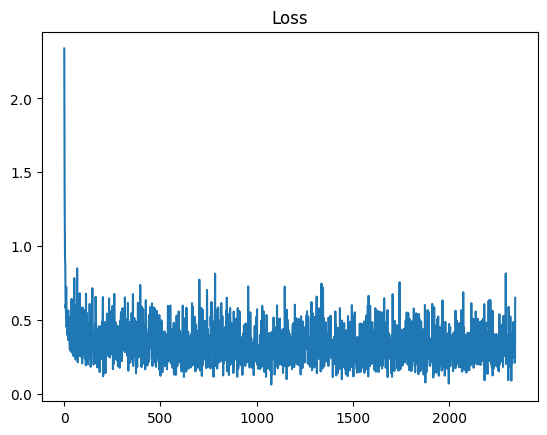

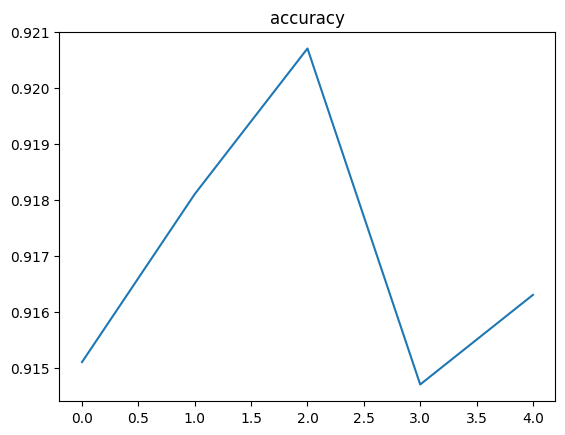

In [31]:
#График лосс и точности модели
plt.plot(v_1,loss_data)
plt.title("Loss")
plt.show()

plt.plot(v_2,acc_data)
plt.title("accuracy")
plt.show()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи.

In [32]:
linear_layer = tf.keras.layers.Dense(10)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for epoch in range(epochs):
    # Iterate over the batches of the dataset.
    for step, (x, y) in enumerate(train_dataset):

        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            logits = linear_layer(x)
            # Loss value for this batch.
            loss = cross_entropy(y, logits)
        # Get gradients of the loss wrt the weights.
        gradients = tape.gradient(loss, linear_layer.trainable_weights)
        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))
        # Logging.
        if step % 100 == 0:
            print("Step:", step, "Loss:", float(loss))
        
    print('Тестирование модели...')
    acc = evaluate(linear_layer, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

Step: 0 Loss: 2.8121426105499268
Step: 100 Loss: 2.0876541137695312
Step: 200 Loss: 1.6752475500106812
Step: 300 Loss: 1.2711068391799927
Step: 400 Loss: 1.1379427909851074
Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1385.65it/s]

Epoch: 0 Accuracy: 0.702
Step: 0 Loss: 1.0628559589385986


Step: 100 Loss: 1.0219520330429077
Step: 200 Loss: 0.8038467764854431
Step: 300 Loss: 0.9837413430213928
Step: 400 Loss: 0.9653091430664062
Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1462.64it/s]

Epoch: 1 Accuracy: 0.7945
Step: 0 Loss: 0.7723873853683472


Step: 100 Loss: 0.6671352982521057
Step: 200 Loss: 1.0182600021362305
Step: 300 Loss: 0.8236898183822632
Step: 400 Loss: 0.7414886355400085
Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1490.21it/s]

Epoch: 2 Accuracy: 0.8309
Step: 0 Loss: 0.6069954633712769


Step: 100 Loss: 0.6102555394172668
Step: 200 Loss: 0.6501181125640869
Step: 300 Loss: 0.5413326025009155
Step: 400 Loss: 0.523280143737793
Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1508.68it/s]

Epoch: 3 Accuracy: 0.8485
Step: 0 Loss: 0.7174623012542725


Step: 100 Loss: 0.5874785780906677
Step: 200 Loss: 0.4994139075279236
Step: 300 Loss: 0.4510667026042938
Step: 400 Loss: 0.4561649560928345
Тестирование модели...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1403.53it/s]

Epoch: 4 Accuracy: 0.8582
